# Evaluation

This notebook focuses on the evaluation of all nowcasting models developed in `modelling-nowcasting-thai-gdp-dec.ipynb` and `modelling-nowcasting-thai-gdp-jan.ipynb`. The main aim is to assess each model in terms of predictive accuracy, interpretability and the trade-off between these two dimensions. The evaluation leverages the results exported from the modelling notebooks, providing a structured comparison across models. Detailed explanations of the evaluation metrics and procedures are discussed in the methodology chapter of the accompanying thesis.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import t
import math
import os

In [2]:
# === LOAD DATA ===

fitted_df_dec = pd.read_csv('./fitted-nowcast-thai-gdp-final-dec.csv')
nowcast_df_dec = pd.read_csv('./results-nowcast-thai-gdp-final-dec.csv')
interpretability_df_dec = pd.read_csv('./interpretability-results-nowcast-thai-gdp-final-dec.csv')
fitted_df_jan = pd.read_csv('./fitted-nowcast-thai-gdp-final-jan.csv')
nowcast_df_jan = pd.read_csv('./results-nowcast-thai-gdp-final-jan.csv')
interpretability_df_jan = pd.read_csv('./interpretability-results-nowcast-thai-gdp-final-jan.csv')

## Accuracy

In [3]:
# === MAE and RMSE ===

# Define MAE helper function
def compute_mae(nowcast_df):
    """
    Compute Mean Absolute Error (MAE) for each model in a nowcasting dataframe.

    Parameters
    ----------
    nowcast_df : pd.DataFrame
        DataFrame containing actual values and model forecasts.
        Must include a column named 'Actual' and one or more forecast columns.
        Columns 'quarter' and 'nowcast_date' (if present) are ignored.

    Returns
    -------
    pd.DataFrame
        A DataFrame where each row corresponds to a model and contains
        its Mean Absolute Error (MAE). The index is the model name,
        and the column is 'MAE'.
    """
    actual = nowcast_df['Actual']
    errors = {}
    for model in nowcast_df.columns:
        if model in ['Actual', 'quarter', 'nowcast_date']:
            continue
        forecast = nowcast_df[model]
        err = forecast - actual
        errors[model] = {
            'MAE': np.mean(np.abs(err))
        }
    return pd.DataFrame(errors).T


# Define RMSFE helper function
def compute_rmsfe(nowcast_df):
    """
    Compute Root Mean Squared Forecast Error (RMSFE) for each model.

    Parameters
    ----------
    nowcast_df : pd.DataFrame
        DataFrame containing actual values and model forecasts.
        Must include a column named 'Actual' and one or more forecast columns.
        Columns 'quarter' and 'nowcast_date' (if present) are ignored.

    Returns
    -------
    pd.DataFrame
        A DataFrame with model names as the index and a single column 'RMSFE',
        representing each model’s root mean squared forecast error.
    """
    actual = nowcast_df['Actual']
    errors = {}
    for model in nowcast_df.columns:
        if model in ['Actual', 'quarter', 'nowcast_date']:
            continue
        forecast = nowcast_df[model]
        err = forecast - actual
        errors[model] = np.sqrt(np.mean(err**2))
    return pd.DataFrame.from_dict(errors, orient='index', columns=['RMSFE'])

In [4]:
# Compute MAE
mae_dec = compute_mae(nowcast_df_dec).rename(columns={'MAE': 'December'}) 
mae_jan = compute_mae(nowcast_df_jan).rename(columns={'MAE': 'January'}) 

# Rename to MultiIndex 
mae_dec.columns = pd.MultiIndex.from_product([['MAE'], ['December']]) 
mae_jan.columns = pd.MultiIndex.from_product([['MAE'], ['January']]) 

# Combine and add MAE Mean 
mae_combined = pd.concat([mae_dec, mae_jan], axis=1) 
mae_combined[('MAE', 'Mean')] = mae_combined.loc[:, pd.IndexSlice['MAE', ['December', 'January']]]\
.mean(axis=1)

# Compute RMSE
nowcast_df_both = pd.concat([nowcast_df_dec, nowcast_df_jan], axis=0)
rmsfe_combined = compute_rmsfe(nowcast_df_both)
rmsfe_combined.columns = pd.MultiIndex.from_product([['RMSFE'], ['Q4']])

# Combine RMSFE and MAE DataFrames
errors_combined = pd.concat([rmsfe_combined, mae_combined], axis=1)
errors_combined = errors_combined.round(4)
errors_combined.index.name = 'Model'

# Sort by RMSFE
errors_combined = errors_combined.sort_values(('RMSFE', 'Q4'))

# Display final Dataframe
errors_combined 

RMSFE      MAE                
                  Q4 December January    Mean
Model                                        
Factor-MIDAS  0.1945   0.1945  0.1945  0.1945
DFM           0.8367   0.0055  1.1832  0.5943
LASSO         0.9062   1.1330  0.5990  0.8660
RF            0.9062   1.1330  0.5990  0.8660
LSTM-MF       0.9142   0.9142  0.9142  0.9142
SVR           0.9175   1.1382  0.6231  0.8807
ERNN-MF       0.9504   0.9504  0.9504  0.9504
kNN           1.2751   1.6286  0.7743  1.2015
AR(1)         1.3801   1.3801  1.3801  1.3801
XGBoost       1.4515   1.6528  1.2175  1.4351
LightGBM      1.7911   1.9007  1.6743  1.7875
Ridge         1.9314   2.3751  1.3488  1.8619
LSTM-SF       3.9396   4.9549  2.5475  3.7512
GRU-SF        4.3785   5.9806  1.6046  3.7926
GRU-MF        6.1939   6.1939  6.1939  6.1939
ERNN-SF       8.6179   9.0951  8.1127  8.6039

In [5]:
# Define helper function for plotting nowcasts and fitted values
def plot_fitted_and_nowcasts(
    fitted_df_dec,
    fitted_df_jan,
    nowcast_df_dec,
    nowcast_df_jan,
    main_title="Nowcast & Fitted GDP",
    source="Source: Your Name",
    save_path=None
):
    """
    Plot fitted and nowcasted GDP data from two different models for comparison.

    Parameters
    ----------
    fitted_df_dec : pd.DataFrame
        DataFrame with fitted values from the December model. Must contain a column
        for actual GDP values ('gdp_growth' or 'Actual') and one or more model forecast columns.
    fitted_df_jan : pd.DataFrame
        DataFrame with fitted values from the January model. Same structure as `fitted_df_dec`.
    nowcast_df_dec : pd.DataFrame
        DataFrame with nowcast values from the December model. 
        Must contain the same model columns as `fitted_df_dec`.
    nowcast_df_jan : pd.DataFrame
        DataFrame with nowcast values from the January model. 
        Must contain the same model columns as `fitted_df_jan`.
    main_title : str, optional
        Main title for the figure (default is "Nowcast & Fitted GDP").
    source : str, optional
        Source text displayed at the bottom of the figure (default is "Source: Your Name").
    save_path : str or None, optional
        File path to save the figure. If None, the figure is displayed (default is None).

    Returns
    -------
    None
        Displays the figure. Saves to `save_path` if provided.
    """
    
    # --- Data Pre-processing ---
    date_col = 'quarter'
    
    # Check for the correct 'actual' column name for fitted data
    actual_col_fitted = 'gdp_growth' if 'gdp_growth' in fitted_df_dec.columns else 'Actual'
    
    # Check for the correct 'actual' column name for nowcast data
    actual_col_nowcast = 'gdp_growth' if 'gdp_growth' in nowcast_df_jan.columns else 'Actual'
    
    excluded_cols = {date_col, "Actual", "gdp_growth"}
    model_cols = [col for col in fitted_df_dec.columns if col not in excluded_cols]
    num_models = len(model_cols)

    # Convert date column to Period dtype for consistent plotting and indexing
    for df in [fitted_df_dec, fitted_df_jan, nowcast_df_dec, nowcast_df_jan]:
        if not isinstance(df[date_col].dtype, pd.PeriodDtype):
            df[date_col] = pd.to_datetime(df[date_col], format='mixed').dt.to_period('Q')
    
    # Prepare actual series, ensuring the last actual value is included for nowcast plotting
    actual_series = fitted_df_dec.set_index(date_col)[actual_col_fitted].sort_index()
    last_actual_quarter = nowcast_df_jan[date_col].iloc[-1]
    
    # Use the correct actual column for the nowcast DataFrame
    last_actual_value = nowcast_df_jan[actual_col_nowcast].iloc[-1]
    
    if last_actual_quarter not in actual_series.index:
        actual_series = pd.concat([actual_series, pd.Series([last_actual_value], 
                                                            index=[last_actual_quarter])])\
        .sort_index()

    # --- Plotting Setup ---
    ncols = 3
    nrows = int(np.ceil(num_models / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows), sharex=True)
    axes = axes.flatten()

    dec_color = "royalblue"
    jan_color = "#FF7F0E"

    # --- Plotting Loop ---
    for i, model in enumerate(model_cols):
        ax = axes[i]
        
        # Plot Actual GDP
        ax.plot(actual_series.index.to_timestamp(), actual_series.values, 
                label='Actual GDP', color='black', marker='o', linewidth=1.5)
        
        # Set the 'date_col' as index before plotting to use .to_timestamp()
        ax.plot(fitted_df_dec.set_index(date_col).index.to_timestamp(), fitted_df_dec[model],
                label='Fitted Dec-17', color=dec_color, linestyle='-', linewidth=2)
        ax.plot(fitted_df_jan.set_index(date_col).index.to_timestamp(), fitted_df_jan[model],
                label='Fitted Jan-31', color=jan_color, linestyle='-', linewidth=2)
        
        # Plot Nowcasts
        nowcast_dec_val = nowcast_df_dec[model].iloc[-1]
        nowcast_jan_val = nowcast_df_jan[model].iloc[-1]
        nowcast_quarter_ts = last_actual_quarter.to_timestamp()
        
        ax.scatter([nowcast_quarter_ts], [nowcast_dec_val], color=dec_color, 
                   marker='o', s=70, label='Nowcast Dec-17')
        ax.scatter([nowcast_quarter_ts], [nowcast_jan_val], color=jan_color, 
                   marker='x', s=70, label='Nowcast Jan-31')
                   
        ax.set_title(f"{model}", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.5)
        
        # Select a subset of ticks to reduce crowding
        xticks = actual_series.index[::4] # Select every 4th quarter
        ax.set_xticks(xticks.to_timestamp())
        ax.set_xticklabels([f"{p.year}Q{p.quarter}" for p in xticks], rotation=45)

    # --- Finalize Plot ---
    # Hide unused subplots
    for j in range(num_models, len(axes)):
        axes[j].set_visible(False)
    
    # Set shared labels
    fig.text(0.20, 0.02, "Quarter", ha='center', fontsize=14)
    fig.text(0.04, 0.5, "GDP Growth (%)", va='center', rotation='vertical', fontsize=14)

    # Create a shared legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96),
        ncol=5, fontsize=10, frameon=True, fancybox=True,
        borderpad=1, edgecolor='gray'
    )
    
    # Add main title and source
    fig.suptitle(main_title, fontsize=16, weight='bold')
    fig.text(0.99, 0.01, source, ha='right', va='bottom', fontsize=9, color='gray')

    # Tight layout with room for title and legend
    plt.tight_layout(rect=[0.05, 0.03, 1, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

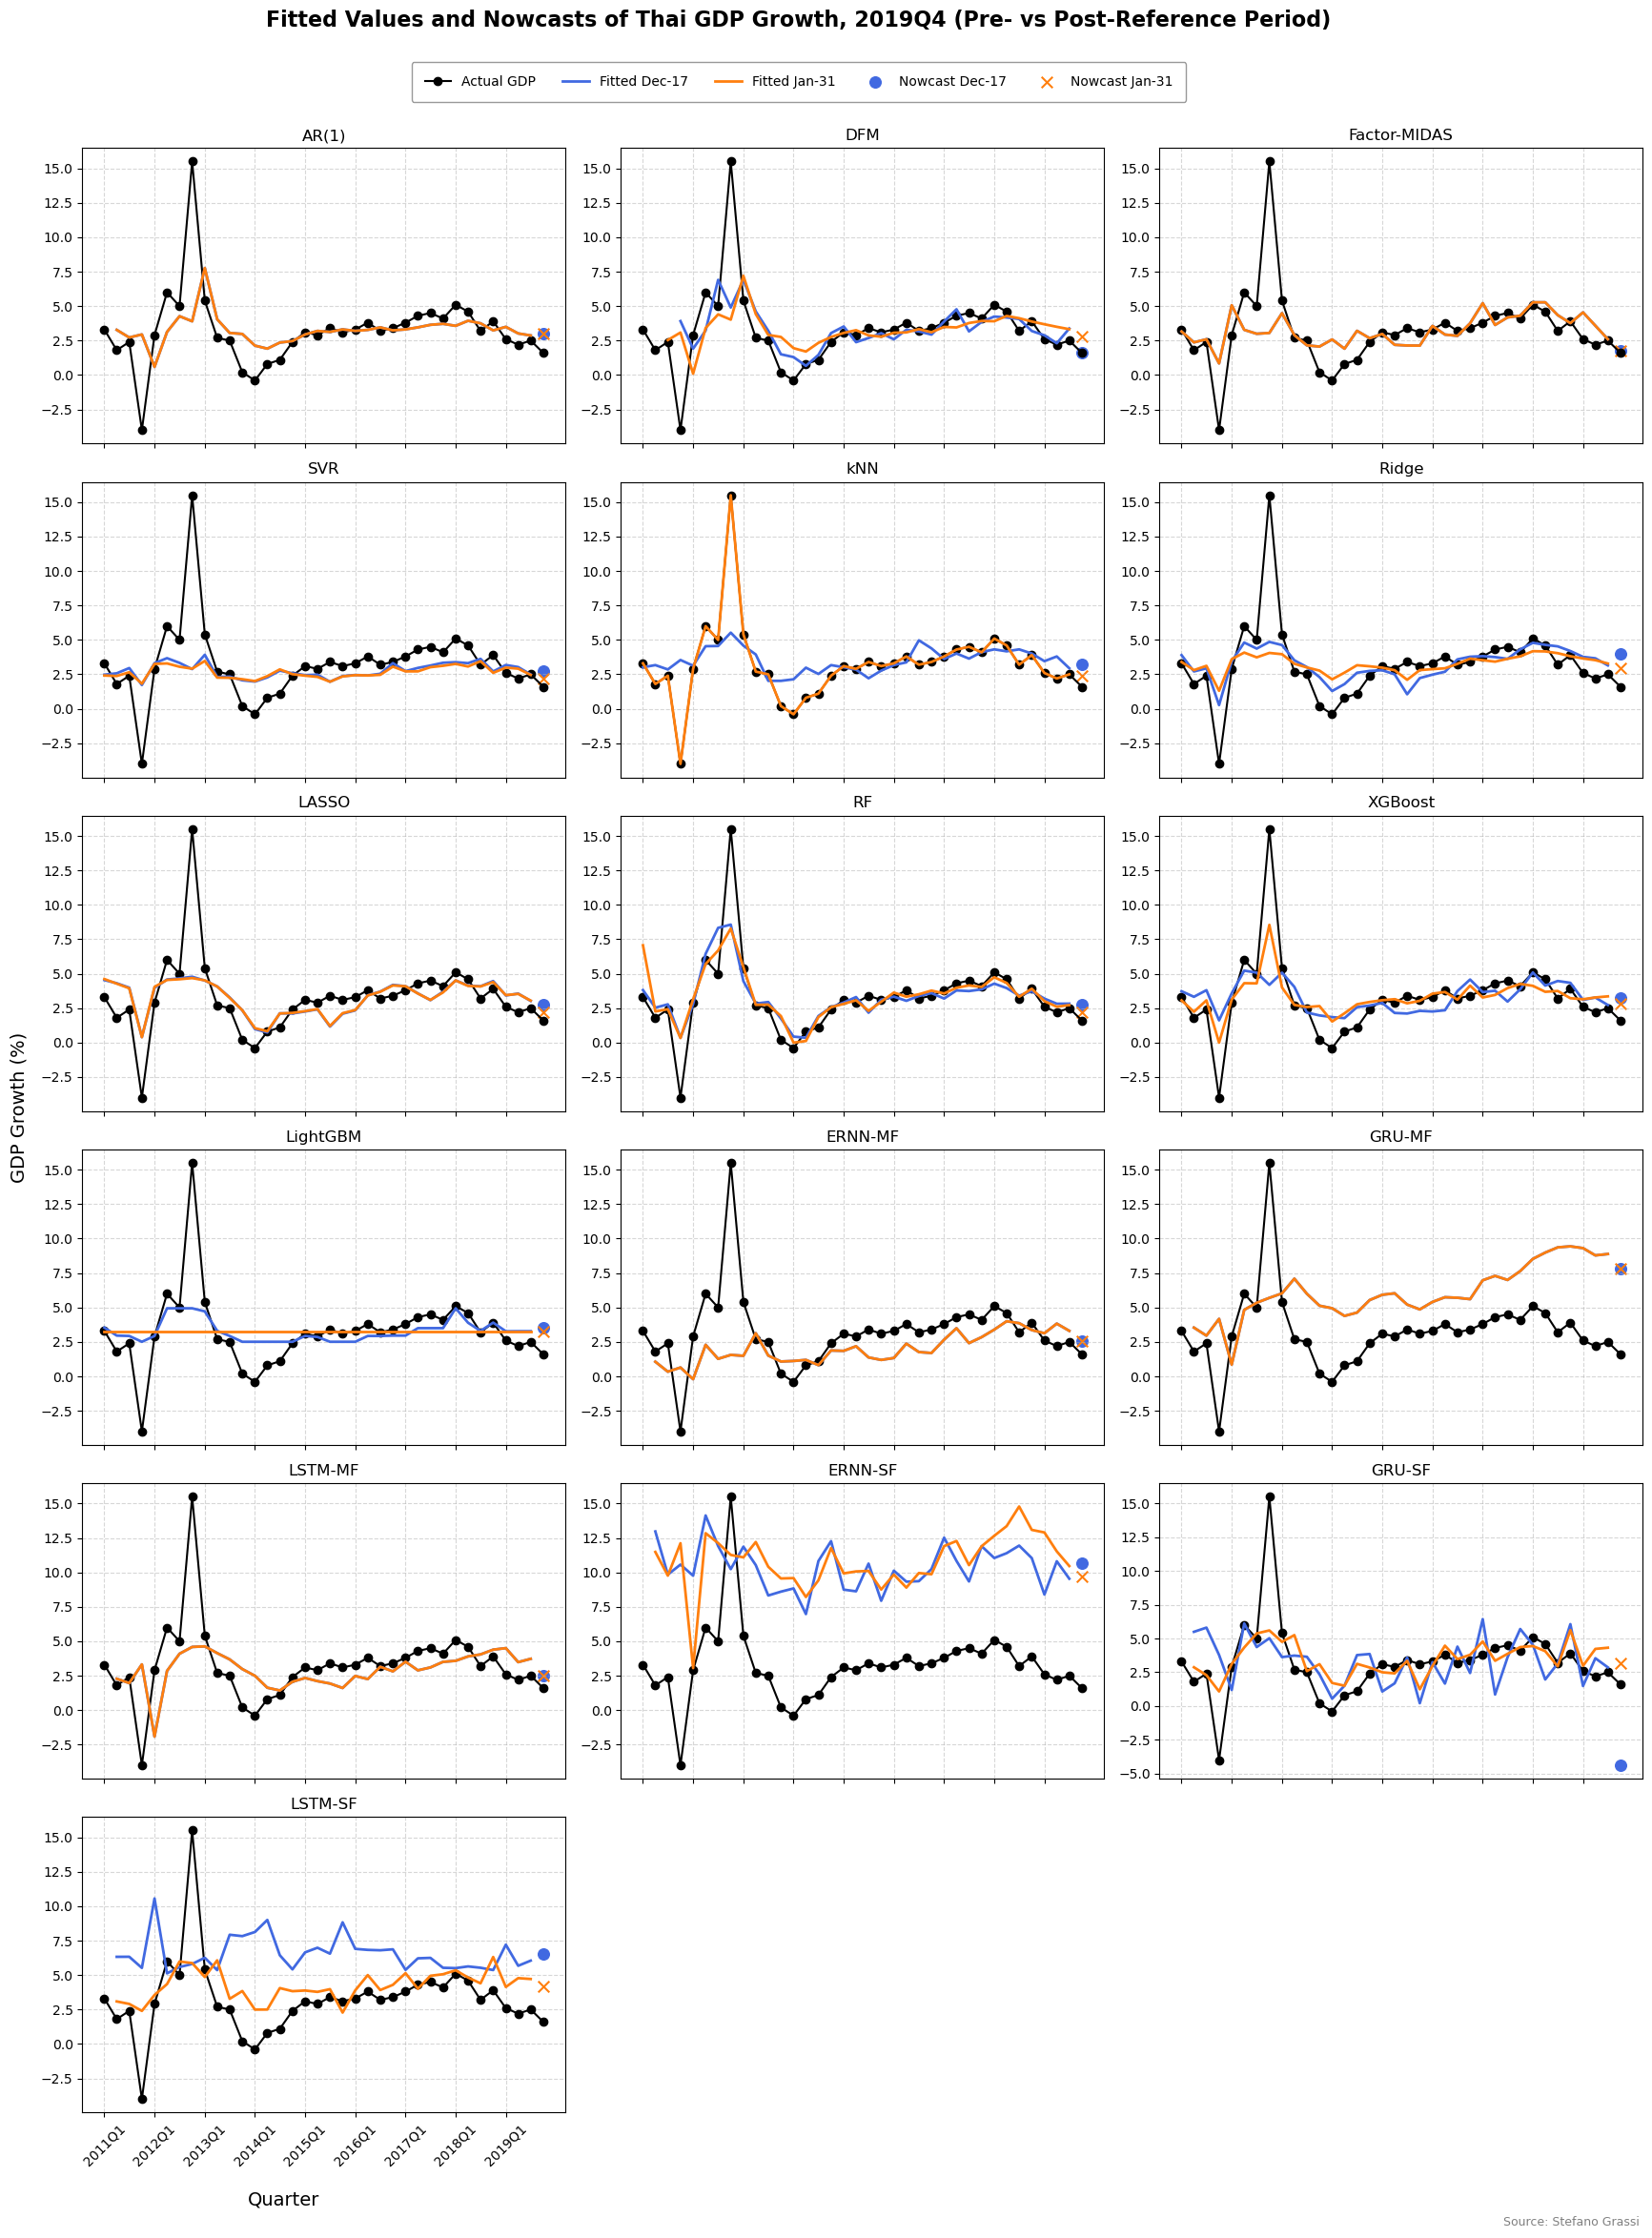

In [6]:
# Plot fitted values and nowcasts
plot_fitted_and_nowcasts(
    fitted_df_dec=fitted_df_dec,
    fitted_df_jan=fitted_df_jan,
    nowcast_df_dec=nowcast_df_dec,
    nowcast_df_jan=nowcast_df_jan,
    main_title="Fitted Values and Nowcasts of Thai GDP Growth, 2019Q4 (Pre- vs Post-Reference Period)",
    source="Source: Stefano Grassi",
    save_path = None #"./thai-gd-models-nowcasts-2019Q4.png"
)

## Interpretability

In [7]:
# === Interpretability DataFrame ===

# Drop non-model columns and transpose
interpret_dec = interpretability_df_dec.drop(columns=['nowcast_date']).T
interpret_jan = interpretability_df_jan.drop(columns=['nowcast_date']).T

# Rename columns
interpret_dec.columns = ['December']
interpret_jan.columns = ['January']

# Merge and format as MultiIndex
interpret_combined = pd.concat([interpret_dec, interpret_jan], axis=1)
interpret_combined.columns = pd.MultiIndex.from_product([['Interpretability'], 
                                                         interpret_combined.columns])
interpret_combined[('Interpretability', 'Mean')] = interpret_combined.mean(axis=1)

# Set model names as index and round
interpret_combined.index.name = 'Model'
interpret_combined = interpret_combined.round(3)
interpret_combined = interpret_combined.sort_values(by=('Interpretability', 'Mean'),
                                                   ascending=False)

# Display the DataFrame
interpret_combined

Interpretability               
                 December January   Mean
Model                                   
kNN                 0.200   1.000  0.600
SVR                 0.000   1.000  0.500
LASSO               0.000   1.000  0.500
RF                  0.091   0.273  0.182
LSTM-SF             0.636  -0.273  0.182
GRU-SF             -0.091  -0.455 -0.273
XGBoost            -0.667   0.091 -0.288
Ridge              -0.636  -0.273 -0.454
LightGBM           -1.000   0.000 -0.500
LSTM-MF            -0.636  -0.636 -0.636
ERNN-SF            -0.636  -0.818 -0.727
ERNN-MF            -0.818  -1.000 -0.909
GRU-MF             -0.818  -1.000 -0.909

## Accuracy vs Interpretability Trade-Off

In [8]:
# Define function for plotting accuracy vs interpretability trade-off
def plot_accuracy_interpretability_tradeoff(
    errors_combined, interpret_combined,
    main_title="Accuracy vs Interpretability Trade-off in Nowcasting Thai GDP ML Models",
    source="Source: Your Name",
    save_path=None
):
    """
    Plot the trade-off between model accuracy and interpretability using a radar chart.

    The function normalizes RMSFE (accuracy) and interpretability values using Min-Max
    scaling. RMSFE is inverted (1 - normalized RMSFE) so that higher values indicate
    better accuracy, aligning the scales of both metrics for visualization.

    Parameters
    ----------
    errors_combined : pd.DataFrame
        DataFrame containing model error metrics. Must include a column 'RMSFE'
        with mean RMSFE values for each model.
    interpret_combined : pd.DataFrame
        DataFrame containing model interpretability metrics. Must include a column
        ('Interpretability', 'Mean') with mean interpretability values for each model.
    main_title : str, optional
        Main title for the radar plot (default is 
        "Accuracy vs Interpretability Trade-off in Nowcasting Thai GDP ML Models").
    source : str, optional
        Source text displayed at the bottom of the figure (default is "Source: Your Name").
    save_path : str or None, optional
        File path to save the figure. If None, the figure is displayed (default is None).

    Returns
    -------
    None
        Displays the radar chart. Saves to `save_path` if provided.
    """
    
    # --- Data Pre-processing ---

    # Extract Mean RMSFE and Interpretability
    rmsfe = errors_combined['RMSFE']
    interpret_mean = interpret_combined[('Interpretability', 'Mean')]

    # Find common models and clean NaNs
    common_models = rmsfe.index.intersection(interpret_mean.index)
    rmsfe = rmsfe.loc[common_models].dropna()
    interpret_mean = interpret_mean.loc[common_models].dropna()

    # Keep intersection after dropping NaNs for alignment
    common_clean_models = rmsfe.index.intersection(interpret_mean.index)
    rmsfe = rmsfe.loc[common_clean_models]
    interpret_mean = interpret_mean.loc[common_clean_models]

    # Ensure Series 
    if isinstance(rmsfe, pd.DataFrame):
        rmsfe = rmsfe.squeeze()
    if isinstance(interpret_mean, pd.DataFrame):
        interpret_mean = interpret_mean.squeeze()

    # Normalize using Min-Max scaling
    def min_max_normalize(series):
        return (series - series.min()) / (series.max() - series.min())

    rmsfe_norm_raw = min_max_normalize(rmsfe)
    # Invert RMSFE scale because lower RMSFE means better accuracy
    rmsfe_norm = 1 - rmsfe_norm_raw

    interpret_norm = min_max_normalize(interpret_mean)

    # Sort models alphabetically for consistent ordering
    sorted_labels = sorted(rmsfe_norm.index)
    rmsfe_norm = rmsfe_norm.loc[sorted_labels]
    interpret_norm = interpret_norm.loc[sorted_labels]

    # Prepare data for radar plot
    labels = rmsfe_norm.index.tolist()
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    rmsfe_values = rmsfe_norm.tolist()
    rmsfe_values += rmsfe_values[:1]

    interpret_values = interpret_norm.tolist()
    interpret_values += interpret_values[:1]

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

    ax.plot(angles, rmsfe_values, color='darkred', linewidth=2, 
            label='Normalized Accuracy (1 - RMSFE)')
    ax.fill(angles, rmsfe_values, color='darkred', alpha=0.25)

    ax.plot(angles, interpret_values, color='royalblue', linewidth=2, 
            label='Normalized Interpretability (LAIS)')
    ax.fill(angles, interpret_values, color='royalblue', alpha=0.25)

    # Set radial limits and gridlines
    ax.set_ylim(0, 1)
    ax.set_yticks([0.25, 0.5, 0.75, 1])
    ax.set_yticklabels(['0.25', '0.5', '0.75', '1'], fontsize=9, color='gray')

    # Now manually shift the labels outward by adjusting their position
    for label in ax.get_yticklabels():
        x, y = label.get_position()
        label.set_position((x + 0.05, y))

    # Labels on the axes
    ax.set_xticks(angles[:-1]) # Close the radar chart by repeating the first angle
    ax.set_xticklabels(labels, fontsize=10)

    ax.set_title(main_title, fontsize=16, weight='bold', y=1.1)

    # Add values on points for clarity
    for angle, r_val, i_val in zip(angles[:-1], rmsfe_values[:-1], interpret_values[:-1]):
        ax.text(angle, r_val - 0.09, f"{r_val:.2f}", color='darkred', fontsize=9,
        ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))
        ax.text(angle, i_val - 0.05, f"{i_val:.2f}", color='royalblue', fontsize=9,
                ha='center', va='top', bbox=dict(facecolor='white', alpha=0.6, 
                                                 edgecolor='none', pad=1))
        

    # Legend
    handles, labels_legend = ax.get_legend_handles_labels()
    fig.legend(
        handles, labels_legend,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.01),
        ncol=1,
        fontsize=12,
        frameon=True,
        fancybox=True,
        borderpad=1,
        edgecolor='gray'
    )

    # Source note
    fig.text(0.99, 0.01, source, ha='right', va='bottom', fontsize=9, color='gray')

    # Tight layout with room for title and legend
    plt.tight_layout(rect=[0.05, 0.03, 1, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

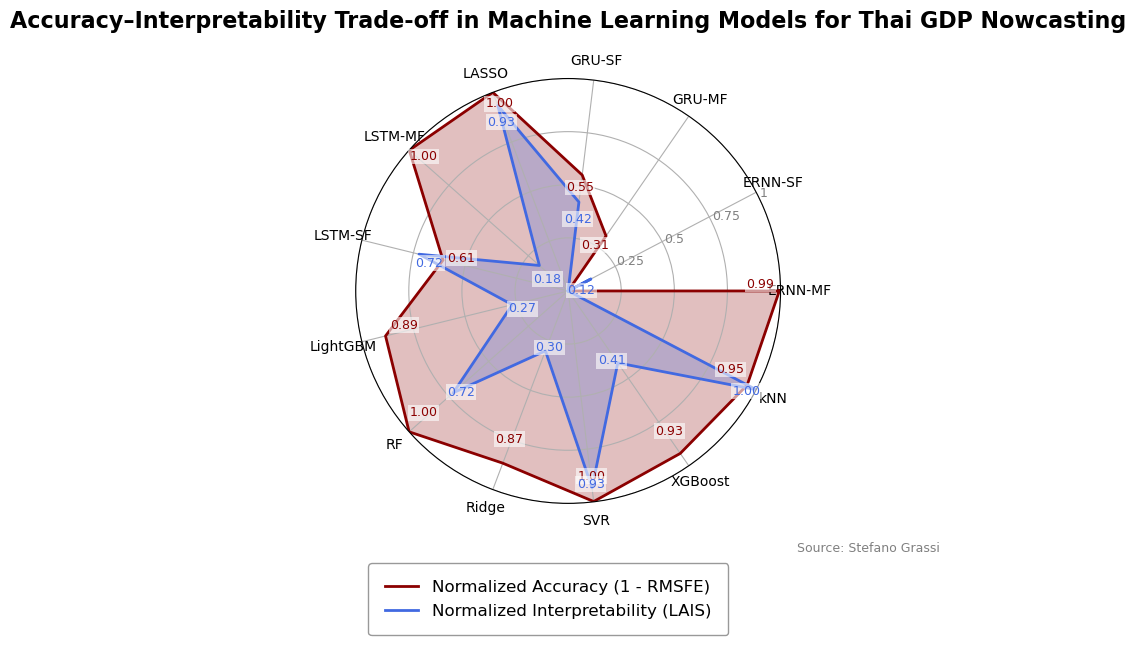

In [9]:
# Plot accuracy vs interpretability trade-off
plot_accuracy_interpretability_tradeoff(
    errors_combined,
    interpret_combined,
    main_title="Accuracy–Interpretability Trade-off in Machine Learning Models for Thai GDP Nowcasting",
    source="Source: Stefano Grassi",
    save_path= None #"./accuracy-vs-interpretability-radar-ml-models-nowcasting-thai-gdp.png"
)